This notebook performs the pre-analysis workflow for low background data (trigger 2).
<br>
The process involves:
- Loading of reconstructed data.
- Correction of energy using $^{83\text{m}}Kr$ maps (FALTA USAR EL FACTOR DE ESCALA DE HE).
- Data cleaning to mitigate artifacts or anomalies arising from the NEXT reconstruction process.
- Application of cuts on $S1$ and $S2$ signals to differentiate and isolate alpha ($\alpha$) and electron ($e$) populations (FALTA ESTABLECER BIEN LOS VALORES DE LOS CORTES).
- Generation of dataframes organized by analysis stage (hit and event-level), particle type ($\alpha$ and $e$).
- Application of selection criteria to separate populations into detector sub-volumes of interest.
- Storage of the processed and categorized information into a single output file per run for subsequent analysis phases.

In [1]:
import sys
sys.path.append('/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/libs')

import crudo
from   invisible_cities.reco.corrections import read_maps                   # type: ignore
from   invisible_cities.reco.corrections import apply_all_correction        # type: ignore
from   invisible_cities.types.symbols    import NormStrategy                # type: ignore
import matplotlib.pyplot as plt                                             # type: ignore  
import numpy as np                                                          # type: ignore
import os
import pandas as pd                                                         # type: ignore
import plotting_tools as pt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Preliminary

In [2]:
# List of low background runs
runs_info = {
                # # Condition 0:  castle = open #
                # 15062: {"duration": 84783, "OK": 69564, "LOST": 1339},
                # 15063: {"duration": 79120, "OK": 65052, "LOST": 1241},
                # 15076: {"duration": 69316, "OK": 56775, "LOST": 1080},
                # # Condition 1:  castle = pclosed & RAS = on #
                # 15288: {"duration": 87256, "OK": 30201, "LOST": 8397},
                # 15289: {"duration": 82152, "OK": 28180, "LOST": 7884},
                # 15290: {"duration": 61295, "OK": 20931, "LOST": 5915},
                # # Condition 2:  castle = pclosed & RAS = off #
                # 15299: {"duration": 60204, "OK": 18014, "LOST": 8929},
                # 15318: {"duration": 86706, "OK": 28735, "LOST": 1011},
                # 15319: {"duration": 85823, "OK": 27973, "LOST": 1008},
                # 15330: {"duration": 86462, "OK": 28157, "LOST": 1043},
                # 15331: {"duration": 85389, "OK": 27390, "LOST": 9966},
                # 15332: {"duration": 67758, "OK": 22010, "LOST": 8142},      # Loosely estimated
                # 15462: {"duration": 39365, "OK": 12847, "LOST": 4532},
                # 15472: {"duration": 86563, "OK": 28505, "LOST": 1001},      # Loosely estimated
                # 15478: {"duration": 86835, "OK": 28702, "LOST": 9999},
                # 15479: {"duration": 86876, "OK": 28713, "LOST": 1003},
                # 15484: {"duration": 86538, "OK": 28188, "LOST": 1046},
                # 15485: {"duration": 86186, "OK": 28281, "LOST": 1030},
                # 15486: {"duration": 86578, "OK": 28700, "LOST": 1036},
                # 15487: {"duration": 86456, "OK": 28703, "LOST": 9952},
                # 15488: {"duration": 86367, "OK": 28891, "LOST": 1004},
                # 15489: {"duration": 60554, "OK": 20059, "LOST": 7031},
                # # Condition 3:  castle = closed & RAS = on #
                # 15502: {"duration": 85477, "OK": 28287, "LOST": 9564},
                # 15504: {"duration": 85194, "OK": 28297, "LOST": 9537},
                # 15505: {"duration": 86517, "OK": 28632, "LOST": 9725},
                # 15506: {"duration": 84841, "OK": 28438, "LOST": 9603},
                # 15507: {"duration": 55740, "OK": 18569, "LOST": 6149},
                # 15514: {"duration": 59207, "OK": 20054, "LOST": 6646},
                # 15519: {"duration": 34045, "OK": 11420, "LOST": 3646},
                # 15520: {"duration": 85170, "OK": 28050, "LOST": 9130},
                # 15521: {"duration": 85388, "OK": 28396, "LOST": 8831},
                # 15527: {"duration": 69725, "OK": 23560, "LOST": 7411},
                # 15528: {"duration": 41361, "OK": 13460, "LOST": 4426},
                # 15535: {"duration": 84904, "OK": 28799, "LOST": 9156},
                # 15539: {"duration": 56567, "OK": 15618, "LOST": 9586},       
                # 15540: {"duration": 67663, "OK": 22526, "LOST": 7066},      
                # 15541: {"duration": 86630, "OK": 29124, "LOST": 9333},
                # 15542: {"duration": 87915, "OK": 29717, "LOST": 9274},
                # 15543: {"duration": 86570, "OK": 29160, "LOST": 9123},
                # 15544: {"duration": 86566, "OK": 29498, "LOST": 9029},
                # 15545: {"duration": 85892, "OK": 29437, "LOST": 8877},
                # 15546: {"duration": 84822, "OK": 28663, "LOST": 8704},
                # 15547: {"duration": 71594, "OK": 24549, "LOST": 7421},
                # 15557: {"duration": 66088, "OK": 22273, "LOST": 6929},

                # ----- P E R I O D  0 2 ----- #
                
                # # Jul 2025: castle = closed & RAS = off #
                # 15609: {"duration": 79563, "OK": 28168, "LOST": 8392},
                # 15614: {"duration": 81279, "OK": 28543, "LOST": 8472},
                # 15615: {"duration": 86302, "OK": 30165, "LOST": 9046},
                # 15616: {"duration": 86146, "OK": 30386, "LOST": 8635},
                # 15617: {"duration": 88041, "OK": 31274, "LOST": 8983},
                # 15618: {"duration": 82577, "OK": 29104, "LOST": 8619},
                # 15619: {"duration": 77964, "OK": 27411, "LOST": 7930},
                # 15621: {"duration": 83287, "OK": 29261, "LOST": 8351},
                # 15622: {"duration": 90371, "OK": 31543, "LOST": 9167},
                # 15623: {"duration": 80748, "OK": 28474, "LOST": 8300},
                # 15624: {"duration": 64650, "OK": 22921, "LOST": 6461},
                # # Aug 2025: castle = closed & RAS = on #
                # 15625: {"duration": 87329, "OK": 30498, "LOST": 8570},
                # 15626: {"duration": -1, "OK": -1, "LOST": -1},  # Waiting Jose Maria
                15627: {"duration": 61872, "OK": 21967, "LOST": 6238},
                # 15632: {"duration": 86709, "OK": 30444, "LOST": 8826},
                # 15633: {"duration": 86076, "OK": 30070, "LOST": 8578},
                # 15634: {"duration": 86545, "OK": 30372, "LOST": 8234},
                # 15635: {"duration": 86545, "OK": 30372, "LOST": 9016}
                       
            }

In [3]:
# Directories with data
data_dir   = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Sophronia/Low_backgrounds/'     # Runs per ldc
icaros_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Icaros/Low_backgrounds/'        # Kr maps per run

# Paths of the tables inside the HDF5 file. These are the keys used to access the datasets
dorothea  = 'DST/Events'
sophronia = 'RECO/Events'

### Dataframes Categorization

In [4]:
# Store the loaded data here
reco_data = {run_id: {
                        'Dorothea' : {}, 
                        'Sophronia': {}
                    } 
            for run_id in runs_info.keys()}

In [5]:
# Store the selected data here
sel_data = {run_id: {
                        'Dorothea':  {'Alpha'   : {}, 'Electron': {}},
                        'Sophronia': {'Alpha'   : {'All': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}, 
                                      'Electron': {'All': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}},
                        'Event':     {'Alpha'   : {'All': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}, 
                                      'Electron': {'All': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}}
                    } 
            for run_id in runs_info.keys()}

### Global Variables

In [6]:
# ----- Drift Velocity ----- #
V_drift = 0.865     # in [mm/μs]

# ----- NO-Polike Parameters ----- #
m_NOPolike = 0.17;  b_NOPolike = -56

# ----- S1e Correction Parameters ----- #
# Cathode temporal position
DT_stop = 1372.2543         # in [μs]
# Fit values
CV_fit = [0.57, 796.53]     # Run 14739 Fit: χ² / ndof = 1.8480

# ----- S1e and S2e Threshold ----- #
S1e_threshold = 900         # in [PE]

# ----- Energy Threshold ----- #
E_threshold = 0.5           # in [MeV]

# Reconstruction

Load the data as it comes from the NEXT reconstruction chain. 
<br>
We store the number of reconstructed events for extra plots in the future.

In [7]:
# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # Run information
    run_OK = runs_info[run_id]['OK']

    # Initialize empty lists to store the dataframes
    run_dst  = []
    run_reco = []
    reco_evts = 0

    # ----- LDC Loop ----- #
    for ldc in range(1, 8):

        # Load the HDF5 file
        h5_path = os.path.join(data_dir, f'run_{run_id}_ldc{ldc}_trg2_sophronia.h5')

        try:

            # ----- Dorothea ----- #
            dst_df = pd.read_hdf(h5_path, key=dorothea)
            reco_evts += dst_df.event.nunique()                   # Number of reco events
            run_dst.append(dst_df)

            # ----- Sophronia ----- #
            reco_df = pd.read_hdf(h5_path, key=sophronia)
            run_reco.append(reco_df)

        except KeyError as e:
            print(f"Warning: Key '{e.args[0]}' not found in file '{h5_path}'. Skipping this file.")

    runs_info[run_id]['Reco_CV'] = reco_evts
    print(f'  Loaded: {reco_evts} events ({reco_evts/run_OK:.2%})')

    # ----- Concatenate Data ----- #
    run_dst_df  = pd.DataFrame()
    run_reco_df = pd.DataFrame()

    if run_dst:
        run_dst_df = pd.concat(run_dst, ignore_index=True)

    if run_reco:
        run_reco_df = pd.concat(run_reco, ignore_index=True)

    # ----- Save Combined Data ----- #
    reco_data[run_id]['Dorothea']  = run_dst_df
    reco_data[run_id]['Sophronia'] = run_reco_df

--- Processing Run 15557 ---
  Loaded: 22026 events (98.89%)
--- Processing Run 15614 ---
  Loaded: 28225 events (98.89%)


## Energy Correction & Cleaning Part 01

__Sophronia__
<br>
We need to correct the energy using the Kr result from Icaros for the corresponding run.

In [8]:
# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # Data
    df = reco_data[run_id]['Sophronia']
    # Rename column 'Z' to 'DT'
    df.rename(columns={'Z': 'DT'}, inplace=True)
    # Event counter
    evt_prior = df['event'].nunique()

    # Kr map
    kr_file = next((f for f in os.listdir(icaros_dir) if f'run_{run_id}' in f and f.endswith('.map.h5')), None)
    if not kr_file:
        raise FileNotFoundError(f"No Kr map file found for run {run_id} in {icaros_dir}")
    kr_path = os.path.join(icaros_dir, kr_file)
    cmap = read_maps(kr_path)

    # Apply corrections
    corr_func = apply_all_correction(cmap, apply_temp=False, norm_strat=NormStrategy.kr)

    # ----- Energy Correction ----- #
    df['corr_factor'] = corr_func(df.X, df.Y, df.DT, df.time)
    df['E_corr'] = df['E'] * df['corr_factor']

    # ---- Cleaning 01 ----- #
    # NaN or negative energy to 0: hit-level
    df['E_corr'] = np.where(
                                pd.notna(df['E_corr']) & (df['E_corr'] > 0),        # Condition
                                df['E_corr'],                                       # Value if condition is True
                                0                                                   # Value if condition is False   
    )

    # Drop events with negative Z: event-level
    Znegative_evt_ids = df.loc[df['DT'] < 0, 'event'].unique()

    if Znegative_evt_ids.size > 0:
        df = df[~df['event'].isin(Znegative_evt_ids)].copy()

    # Compute real Z position: using the drift velocity
    df['Z'] = df['DT'] * V_drift

    # ----- Good Events ID: Part 01 ----- #
    good_evt_ids = df['event'].unique()

    print(f"  After drop negative Z: {len(good_evt_ids)} events ({len(good_evt_ids)/evt_prior:.2%})")

    # ----- Store Data ----- #
    reco_data[run_id]['Dorothea']  = reco_data[run_id]['Dorothea'][reco_data[run_id]['Dorothea']['event'].isin(good_evt_ids)].copy()     # Keep only events with good sophronia info
    reco_data[run_id]['Sophronia'] = df.copy()

--- Processing Run 15557 ---
  After drop negative Z: 19355 events (87.87%)
--- Processing Run 15614 ---
  After drop negative Z: 20811 events (73.73%)


## $S1$ Signal

__Dorothea__
<br>
- __nS1 = 0__ : These are events associated to the _anode_!
- __nS1 = 1__: The $S1$ energy distribution allow us to distinguish between the $\alpha$ population or the $e^{-}$ population that are within the HE datasets.
<br> 
Also, along with the $S1$ height, we can avoid what it looks to be the Po-like population (see $\alpha$ analysis in $\text{Xe}$).

In [9]:
# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # Data
    df = reco_data[run_id]['Dorothea']
    # Event counter
    evt_prior = df['event'].nunique()

    # ----- Counters for Efficiencies ----- #
    nS1_0_evt_ids = df.loc[df['nS1'] == 0, 'event'].unique();   print(f"    nS1 = 0: {len(nS1_0_evt_ids)} events ({len(nS1_0_evt_ids)/evt_prior:.2%})")
    nS1_1_evt_ids = df.loc[df['nS1'] == 1, 'event'].unique();   print(f"    nS1 = 1: {len(nS1_1_evt_ids)} events ({len(nS1_1_evt_ids)/evt_prior:.2%})")
    
    # ----- S1 Signal ----- #
    df = df[(df['nS1'] == 0) | ((df['nS1'] == 1) & (df['S1h'] >= m_NOPolike * df['S1e'] + b_NOPolike))].copy()

    # Events with S1 signal above the NO-Polike threshold
    nS1_NOPolike = df.loc[df['nS1'] == 1, 'event'].unique();      print(f"      NO Po-like: {len(nS1_NOPolike)} events ({len(nS1_NOPolike)/len(nS1_1_evt_ids):.2%})")

    # ----- S1e Correction ----- #
    df = crudo.correct_S1e(df, CV_fit, DT_stop, output_column='S1e_corr')    # I'll work with this corrected S1 energy
    # Check if the correction was applied
    if 'S1e_corr' not in df.columns:
        print(f"Error: S1e correction not applied! Skipping...")
        continue

    # ----- Good Events ID ----- #
    good_evt_ids = df['event'].unique()

    print(f"  After S1 signal cuts: {len(good_evt_ids)} events ({len(good_evt_ids)/evt_prior:.2%})")

    # ----- Store Data ----- #
    reco_data[run_id]['Dorothea']  = df.copy()
    reco_data[run_id]['Sophronia'] = reco_data[run_id]['Sophronia'][reco_data[run_id]['Sophronia']['event'].isin(good_evt_ids)].copy()


--- Processing Run 15557 ---
    nS1 = 0: 1727 events (8.92%)
    nS1 = 1: 16337 events (84.41%)
      NO Po-like: 13353 events (81.73%)
  After S1 signal cuts: 15080 events (77.91%)
--- Processing Run 15614 ---
    nS1 = 0: 2232 events (10.73%)
    nS1 = 1: 17470 events (83.95%)
      NO Po-like: 15432 events (88.33%)
  After S1 signal cuts: 17664 events (84.88%)


### $\alpha$ and $e$ Populations

Now, let's define an appropiate value for the $S1$ energy cut.
<br>
The precise cut value should be computed from the $S1e$ vs. $E$ plot using $^{228}\text{Th}$ data (because of stats).

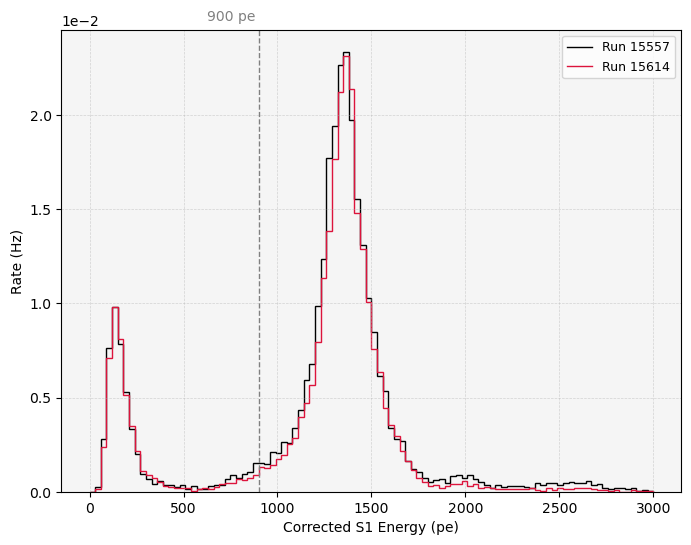

In [10]:
# Global
n_bins = 100
x_min, x_max = 0, 3e3
x_edges = np.linspace(x_min, x_max, n_bins + 1)

plt.figure(figsize=(8, 6))

# ----- Run Loop ----- #
for i, run_id in enumerate(runs_info.keys()):

    # Run information
    run_long = runs_info[run_id]['duration']
    run_DAQe = runs_info[run_id]['OK'] / (runs_info[run_id]['OK'] + runs_info[run_id]['LOST'])

    # Data
    df = reco_data[run_id]['Dorothea']
    
    # Variables
    E1 = df['S1e_corr']

    # Histogram: normalized by corrected DAQ data taking time
    E1_counts, E1_edges = np.histogram(E1, bins=x_edges)
    E1_rate = E1_counts / (run_long * run_DAQe)

    # ----- Plotting ----- #
    plt.stairs(E1_rate, E1_edges, label=f'Run {run_id}', 
               fill=False, lw=1.0, ec=pt.hist_colors[i % len(pt.hist_colors)])
    
# S1 energy threshold
plt.axvline(x=S1e_threshold, color='gray', ls='--', lw=1)
plt.text(0.98*S1e_threshold, 2.5e-2, f'{S1e_threshold} pe', c='gray', ha='right')

# ----- Styling ----- #
plt.xlabel('Corrected S1 Energy (pe)')
plt.ylabel('Rate (Hz)')
# plt.yscale('log')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2, -2))
plt.legend(loc='best', fontsize=9)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

In [11]:
# Apply selection
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # Data
    df_dst  = reco_data[run_id]['Dorothea']
    df_reco = reco_data[run_id]['Sophronia']

    # ----- Just nS1 = 1 Events ----- #
    df_dst = df_dst[df_dst['nS1'] == 1].copy()
    # Event counter
    evt_prior = df_dst['event'].nunique()
    print(f" With nS1 = 1 ({evt_prior} events)")

    # Event IDs for alphas and electrons
    elec_ids  = df_dst.loc[df_dst['S1e_corr'] <= S1e_threshold, 'event'].unique()
    alpha_ids = df_dst.loc[df_dst['S1e_corr'] >  S1e_threshold, 'event'].unique() 

    # ----- Storing Data ----- #
    sel_data[run_id]['Dorothea']['Electron']['All'] = df_dst[df_dst['event'].isin(elec_ids)].copy()
    sel_data[run_id]['Dorothea']['Alpha']['All'] = df_dst[df_dst['event'].isin(alpha_ids)].copy()


    sel_data[run_id]['Sophronia']['Electron']['All'] = df_reco[df_reco['event'].isin(elec_ids)].copy()
    print(f"  Electron candidates: {len(elec_ids)} events ({len(elec_ids)/evt_prior:.2%}) ")

    sel_data[run_id]['Sophronia']['Alpha']['All'] = df_reco[df_reco['event'].isin(alpha_ids)].copy()
    print(f"  Alphas candidates: {len(alpha_ids)} events ({len(alpha_ids)/evt_prior:.2%}) ")

--- Processing Run 15557 ---
 With nS1 = 1 (13353 events)
  Electron candidates: 2231 events (16.71%) 
  Alphas candidates: 11341 events (84.93%) 
--- Processing Run 15614 ---
 With nS1 = 1 (15432 events)
  Electron candidates: 2732 events (17.70%) 
  Alphas candidates: 12858 events (83.32%) 


## $S2$ Signal

__Dorothea__

This particulart part is for events associated to the _anode_ (__nS1 = 0__).

### $\alpha$ and $e$ Populations

Now, let's define an appropiate value for the $S2$ energy cut.
<br>
The precise cut value should be computed from the $S2e$ vs. $E$ plot using $^{228}\text{Th}$ data (because of stats).

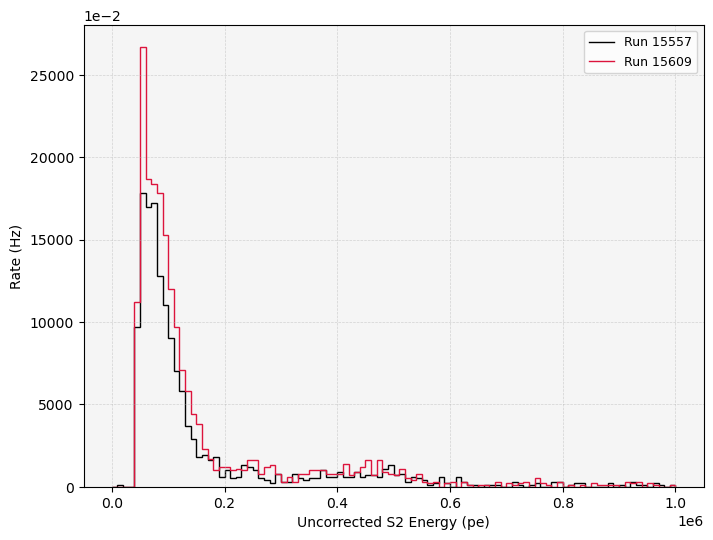

In [ ]:
# Global
n_bins = 100
x_min, x_max = 0, 1e6
x_edges = np.linspace(x_min, x_max, n_bins + 1)

plt.figure(figsize=(8, 6))

# ----- Run Loop ----- #
for i, run_id in enumerate(runs_info.keys()):

    # Run information
    run_long = runs_info[run_id]['duration']
    run_DAQe = runs_info[run_id]['OK'] / (runs_info[run_id]['OK'] + runs_info[run_id]['LOST'])

    # Data
    df = reco_data[run_id]['Dorothea']
    df = df[df['nS1'] == 0].copy()
    df = df[df['nS2'] == 1].copy()  # Just S2 = 1 events
    
    # Variables
    E2 = df['S2e']

    # Histogram: normalized by corrected DAQ data taking time
    E2_counts, E2_edges = np.histogram(E2, bins=x_edges)
    E2_rate = E2_counts / (run_long * run_DAQe)

    # ----- Plotting ----- #
    plt.stairs(E2_counts, E2_edges, label=f'Run {run_id}', 
               fill=False, lw=1.0, ec=pt.hist_colors[i % len(pt.hist_colors)])
    
# S1 energy threshold
# plt.axvline(x=S1e_threshold, color='gray', ls='--', lw=1)
# plt.text(0.98*S1e_threshold, 2.5e-2, f'{S1e_threshold} pe', c='gray', ha='right')

# ----- Styling ----- #
plt.xlabel('Uncorrected S2 Energy (pe)')
plt.ylabel('Rate (Hz)')
# plt.yscale('log')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2, -2))
plt.legend(loc='best', fontsize=9)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

## Testing Zone

In [ ]:
sel_alpha = sel_data[15609]['Sophronia']['Alpha']['All']
sel_elec  = sel_data[15609]['Sophronia']['Electron']['All']

In [ ]:
sel_alpha

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,DT,Q,E,Qc,Ec,track_id,Ep,corr_factor,E_corr,Z
7247,729,1.753110e+09,27,49.755565,-147.234296,1,-328.125,-387.125,0.0,0.0,1329.736125,6.975953,-2.553609,-1.0,NaN,-1,-1.0,0.000006,0.000000,1150.221748
7248,729,1.753110e+09,27,49.755565,-147.234296,1,-343.675,-217.075,0.0,0.0,1329.736125,6.077842,-2.224848,-1.0,-0.000013,-1,-1.0,0.000006,0.000000,1150.221748
7249,729,1.753110e+09,27,49.755565,-147.234296,1,-3.575,399.425,0.0,0.0,1329.736125,5.152738,-1.886205,-1.0,-0.000011,-1,-1.0,0.000006,0.000000,1150.221748
7250,729,1.753110e+09,27,49.755565,-147.234296,1,-173.625,414.975,0.0,0.0,1335.333750,7.042091,-1.699424,-1.0,-0.000012,-1,-1.0,0.000008,0.000000,1155.063694
7251,729,1.753110e+09,27,49.755565,-147.234296,1,-81.325,137.075,0.0,0.0,1335.333750,6.499286,-1.568432,-1.0,-0.000008,-1,-1.0,0.000005,0.000000,1155.063694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101306315,2116996,1.753189e+09,28,-224.906270,46.941616,1,-65.775,-139.825,0.0,0.0,1449.281250,5.244312,15.463668,-1.0,0.000082,-1,-1.0,0.000005,0.000082,1253.628281
101306316,2116996,1.753189e+09,28,-224.906270,46.941616,1,-81.325,-31.975,0.0,0.0,1449.281250,5.550265,16.365817,-1.0,0.000086,-1,-1.0,0.000005,0.000086,1253.628281
101306317,2116996,1.753189e+09,28,-224.906270,46.941616,1,-65.775,91.425,0.0,0.0,1449.281250,5.864106,17.291227,-1.0,0.000092,-1,-1.0,0.000005,0.000091,1253.628281
101306318,2116996,1.753189e+09,28,-224.906270,46.941616,1,-112.425,461.625,0.0,0.0,1449.281250,5.378938,15.860632,-1.0,0.000164,-1,-1.0,0.000006,0.000092,1253.628281


In [ ]:
sel_elec

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,DT,Q,E,Qc,Ec,track_id,Ep,corr_factor,E_corr,Z
89109,14694,1.753110e+09,20,51.523794,177.289798,1,-451.525,229.875,0.0,0.0,528.780000,5.033310,-2.731857,-1.0,NaN,-1,-1.0,NaN,0.000000,457.394700
89110,14694,1.753110e+09,20,51.523794,177.289798,1,227.675,106.975,0.0,0.0,528.780000,6.921737,-3.756811,-1.0,-0.000019,-1,-1.0,0.000005,0.000000,457.394700
89111,14694,1.753110e+09,20,51.523794,177.289798,1,-281.475,122.025,0.0,0.0,532.752875,6.076465,-1.427591,-1.0,-0.000008,-1,-1.0,0.000005,0.000000,460.831237
89112,14694,1.753110e+09,20,51.523794,177.289798,1,119.825,-402.175,0.0,0.0,532.752875,5.613104,-1.318730,-1.0,-0.000008,-1,-1.0,0.000006,0.000000,460.831237
89113,14694,1.753110e+09,20,51.523794,177.289798,1,396.725,-16.925,0.0,0.0,532.752875,5.886959,-1.383069,-1.0,-0.000008,-1,-1.0,0.000006,0.000000,460.831237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101283104,2111368,1.753189e+09,27,2.546672,89.837761,1,-235.825,91.425,0.0,0.0,379.102250,5.355975,0.721003,-1.0,0.000004,-1,-1.0,0.000005,0.000004,327.923446
101283105,2111368,1.753189e+09,27,2.546672,89.837761,1,-34.675,-109.725,0.0,0.0,379.102250,5.379641,0.724189,-1.0,0.000004,-1,-1.0,0.000005,0.000004,327.923446
101283106,2111368,1.753189e+09,27,2.546672,89.837761,1,104.275,461.625,0.0,0.0,379.102250,5.529900,0.744416,-1.0,0.000007,-1,-1.0,0.000006,0.000004,327.923446
101283107,2111368,1.753189e+09,27,2.546672,89.837761,1,458.925,122.025,0.0,0.0,379.102250,5.003932,0.673612,-1.0,0.000005,-1,-1.0,0.000008,0.000005,327.923446


## Cleaning Isolated Hits

__Sophronia__
<br>
Clean up those damn spurious hits! Just use the function for $e$ population.
<br>
The cleaning for $\alpha$ population is made with just a cut on charge at the end of the processing.

In [12]:
test_soph = sel_data[15614]['Sophronia']['Electron']['All'].copy()

In [13]:
test_soph

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,DT,Q,E,Qc,Ec,track_id,Ep,corr_factor,E_corr,Z
12737,3018,1.753203e+09,25,61.527255,17.365202,1,-50.225,-278.775,0.0,0.0,1244.326000,5.522849,-0.546820,-1.0,-2.960080e-06,-1,-1.0,0.000005,0.000000e+00,1076.341990
12738,3018,1.753203e+09,25,61.527255,17.365202,1,73.175,13.675,0.0,0.0,1244.326000,8.951080,-0.886251,-1.0,-4.679322e-06,-1,-1.0,0.000005,0.000000e+00,1076.341990
12739,3018,1.753203e+09,25,61.527255,17.365202,1,243.225,137.075,0.0,0.0,1244.326000,5.303557,-0.525108,-1.0,-2.888958e-06,-1,-1.0,0.000005,0.000000e+00,1076.341990
12740,3018,1.753203e+09,25,61.527255,17.365202,1,165.475,461.625,0.0,0.0,1244.326000,6.313276,-0.625081,-1.0,NaN,-1,-1.0,0.000006,0.000000e+00,1076.341990
12741,3018,1.753203e+09,25,61.527255,17.365202,1,257.775,153.125,0.0,0.0,1244.326000,9.373915,-0.928116,-1.0,-5.113424e-06,-1,-1.0,0.000005,0.000000e+00,1076.341990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102468942,2066841,1.753284e+09,30,-19.794197,-16.943105,1,73.175,-417.725,0.0,0.0,1371.213125,5.001897,0.042569,-1.0,2.531414e-07,-1,-1.0,0.000006,2.514916e-07,1186.099353
102468943,2066841,1.753284e+09,30,-19.794197,-16.943105,1,26.525,-247.675,0.0,0.0,1371.213125,6.846951,0.058272,-1.0,3.177236e-07,-1,-1.0,0.000005,3.167410e-07,1186.099353
102468944,2066841,1.753284e+09,30,-19.794197,-16.943105,1,73.175,44.775,0.0,0.0,1371.213125,6.308823,0.053692,-1.0,2.819762e-07,-1,-1.0,0.000005,2.797835e-07,1186.099353
102468945,2066841,1.753284e+09,30,-19.794197,-16.943105,1,288.875,353.275,0.0,0.0,1371.213125,9.307064,0.079209,-1.0,5.721827e-07,-1,-1.0,0.000008,6.121962e-07,1186.099353


In [14]:
# Cut on charge for alpha hits
Q_lim = 100         # in [pe]

# Setting up the filter of spurious hits
# filter_config = {'distance': [15., 15.], 'nhit': 3, 'variables': ['E_corr']}
# NO_hits_sp = crudo.drop_isolated_clusters(**filter_config)
NO_hits_sp = crudo.drop_isolated_clusters_3D(distance = [16., 16., 4.], nhit = 8, variables = ['E_corr'])

# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # ----- Cleaning for Electrons ----- #
    for particle in ['Alpha', 'Electron']:

        # Data
        df = sel_data[run_id]['Sophronia'][particle]['All'];      evt_prior = df['event'].nunique()
        print(f"      → {particle} ({evt_prior} events, {len(df)} hits)")

        if particle == 'Alpha':

            # Apply charge cut for alpha hits
            df = df[df['Q'] >= Q_lim].copy()
            print(f"  Clean {particle}: {df['event'].nunique()} events ({df['event'].nunique()/evt_prior:.2%}), {len(df)} hits ")

        elif particle == 'Electron':
  
            # Drop isolated clusters of hits
            df = df.groupby(['event', 'npeak'], group_keys=False).apply(NO_hits_sp)
            df = df.reset_index(drop=True)
            print(f"  Clean {particle}: {df['event'].nunique()} events ({df['event'].nunique()/evt_prior:.2%}), {len(df)} hits \n")

        # ----- Good Events ID ----- #
        good_evt = df['event'].unique()

        # ----- Store Data ----- #
        sel_data[run_id]['Dorothea'][particle]['All']  =  sel_data[run_id]['Dorothea'][particle]['All'][sel_data[run_id]['Dorothea'][particle]['All']['event'].isin(good_evt)].copy()
        sel_data[run_id]['Sophronia'][particle]['All'] = df.copy()

--- Processing Run 15557 ---
      → Alpha (11341 events, 27273745 hits)
  Clean Alpha: 11340 events (99.99%), 1399821 hits 
      → Electron (2231 events, 1251854 hits)
  Clean Electron: 2231 events (100.00%), 1030107 hits 

--- Processing Run 15614 ---
      → Alpha (12858 events, 46268622 hits)
  Clean Alpha: 12854 events (99.97%), 1547029 hits 
      → Electron (2732 events, 2511155 hits)
  Clean Electron: 2732 events (100.00%), 1492770 hits 



## Data @ Event-level 

Here, a new __event-level__ (different to _Dorothea_) representation of the data is generated. 
<br>
The $XYZ$ position for each event is computed as the energy-weighted sum of constituent hits, defined as:

$X_\text{event} = \frac{\sum E_{\text{hit}}\cdot X_{\text{hit}}}{\sum E_{\text{hit}}}$

In [15]:
# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Alpha', 'Electron']:  

        # Data
        df = sel_data[run_id]['Sophronia'][particle]['All']

        # Group sophronia data by event
        reco_evt  = df.groupby('event')
        events_df = []

        for i, event in enumerate(reco_evt):

            # Event info
            event_id   = event[0]
            event_data = event[1]

            # Variables
            T = event_data['time']
            X = event_data['X']
            Y = event_data['Y']
            Z = event_data['Z']
            E = event_data['E_corr']

            # Compute event-level weighted averages and sums
            T_evt = np.mean(T)             # Mean time
            E_evt = np.sum(E)              # Total energy
            X_evt = np.sum(E * X) / E_evt  # Energy-weighted X
            Y_evt = np.sum(E * Y) / E_evt  # Energy-weighted Y
            Z_evt = np.sum(E * Z) / E_evt  # Energy-weighted Z

            # Create a dataframe for the event-level information
            df_evt = pd.DataFrame({'event': [event_id], 'time': [T_evt], 'X': [X_evt], 'Y': [Y_evt], 'Z': [Z_evt], 'E_corr': [E_evt]})
            events_df.append(df_evt)

        # Combine event-level dataframes for the run
        sel_data[run_id]['Event'][particle]['All'] = pd.concat(events_df, ignore_index=True)

--- Processing Run 15557 ---
--- Processing Run 15614 ---


#### Efficiency of the trigger 02.

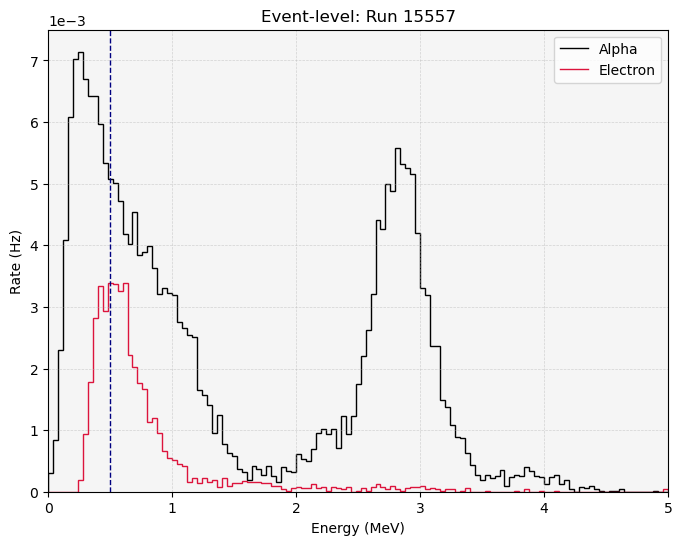

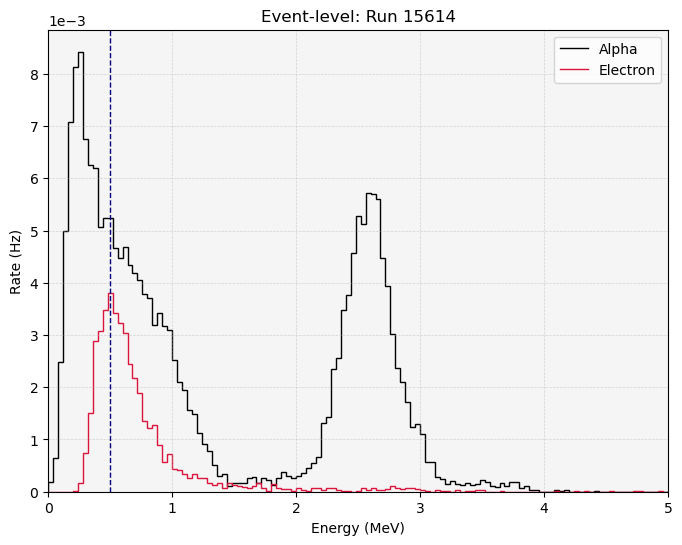

In [16]:
# Global
n_bins = 250
x_min, x_max = 0, 10
x_edges = np.linspace(x_min, x_max, n_bins + 1)

# Energy threshold
E_trigger = 0.5

# ----- Run Loop ----- #
for run_id in runs_info.keys():

    # Run information
    run_long = runs_info[run_id]['duration']
    run_DAQe = runs_info[run_id]['OK'] / (runs_info[run_id]['OK'] + runs_info[run_id]['LOST'])

    plt.figure(figsize=(8, 6))

    # ----- Plotting for Alphas and Electrons ----- #
    for j, particle in enumerate(['Alpha', 'Electron']):

        # Data
        df = sel_data[run_id]['Event'][particle]['All']
    
        # Variables
        E = df['E_corr']

        # Histogram: normalized by corrected DAQ data taking time
        E_counts, E_edges = np.histogram(E, bins=x_edges)
        E_rate = E_counts / (run_long * run_DAQe)

        # ----- Plotting ----- #
        plt.stairs(E_rate, E_edges, label=f'{particle}', 
                   fill=False, lw=1.0, ec=pt.hist_colors[j % len(pt.hist_colors)])
    

    # Energy threshold due to trigger 2 efficiency
    plt.axvline(x=E_trigger, color='navy', ls='--', lw=1)

    # Styling
    plt.xlabel('Energy (MeV)')
    plt.xlim(0, 5)
    plt.ylabel('Rate (Hz)')
    # plt.yscale('log')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
    plt.legend(fontsize=10, loc='best')
    plt.title(f'Event-level: Run {run_id}')

    plt.grid(True, ls='--', lw=0.5, alpha=0.5)
    plt.gca().set_facecolor("whitesmoke")
    plt.show()

In [17]:
# Apply selection
for run_id in runs_info.keys():

    print(f"\n--- Processing Run {run_id} ---\n")

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Alpha', 'Electron']:

        # Data
        df_doro  = sel_data[run_id]['Dorothea'][particle]['All'];       evts_prior = df_doro['event'].nunique()
        df_reco = sel_data[run_id]['Sophronia'][particle]['All']
        df_evt  = sel_data[run_id]['Event'][particle]['All']

        # Event IDs for alphas and electrons
        evt_ids = df_evt.loc[df_evt['E_corr'] >= E_threshold, 'event'].unique()

        # ----- Storing Data ----- #
        sel_data[run_id]['Dorothea'][particle]['All'] = df_doro.loc[df_doro['event'].isin(evt_ids)].copy()
        print(f"  {particle}: {len(evt_ids)} events ({len(evt_ids)/evts_prior:.2%})")

        sel_data[run_id]['Sophronia'][particle]['All'] = df_reco.loc[df_reco['event'].isin(evt_ids)]

        sel_data[run_id]['Event'][particle]['All'] = df_evt.loc[df_evt['event'].isin(evt_ids)]


--- Processing Run 15557 ---

  Alpha: 8245 events (72.71%)
  Electron: 1528 events (68.49%)

--- Processing Run 15614 ---

  Alpha: 8833 events (68.72%)
  Electron: 1869 events (68.41%)


# Selection

## $nS2 = 1$

In [18]:
# Apply selection
for run_id in runs_info.keys():

    print(f"\n--- Processing Run {run_id} ---\n")

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Alpha', 'Electron']:

        # Data
        df_doro  = sel_data[run_id]['Dorothea'][particle]['All'];       evts_prior = df_doro['event'].nunique()
        df_reco = sel_data[run_id]['Sophronia'][particle]['All']
        df_evt  = sel_data[run_id]['Event'][particle]['All']

        # ----- nS2 = 1 ----- #
        df_doro = df_doro[df_doro['nS2'] == 1].copy()

        # Event IDs
        evt_ids = df_doro['event'].unique()

        # ----- Storing Data ----- #
        sel_data[run_id]['Dorothea'][particle]['All'] = df_doro.copy()
        print(f"  {particle}: {len(evt_ids)} events ({len(evt_ids)/evts_prior:.2%})")

        sel_data[run_id]['Sophronia'][particle]['All'] = df_reco.loc[df_reco['event'].isin(evt_ids)]

        sel_data[run_id]['Event'][particle]['All'] = df_evt.loc[df_evt['event'].isin(evt_ids)]


--- Processing Run 15557 ---

  Alpha: 7370 events (89.39%)
  Electron: 1107 events (72.45%)

--- Processing Run 15614 ---

  Alpha: 8059 events (91.24%)
  Electron: 1530 events (81.86%)


## Detector Regions

In [19]:
# Containment limits definition 
Z_low = 40          # in [mm]
Z_up  = 1147        # in [mm]
R_up  = 451.65      # in [mm]

In [20]:
# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"\n--- Processing Run {run_id} ---")

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Alpha', 'Electron']:

        print(f"\n→ {particle}:")

        # Data
        df_reco = sel_data[run_id]['Sophronia'][particle]['All'];     evts_prior = df_reco['event'].nunique()
        df_evt  = sel_data[run_id]['Event'][particle]['All']

        # Group sophronia data by event
        soph_evt = df_reco.groupby('event')

        # Event IDs containers for each detector region
        fiducial_ids = []
        tube_ids     = []
        anode_ids    = []
        cathode_ids  = []

        for i, evt in enumerate(soph_evt):
            
            # Event info
            event_id   = evt[0]
            event_data = evt[1]

            # Variables
            R_hits = np.sqrt(event_data['X']**2 + event_data['Y']**2)
            Z_hits = event_data['Z']

            # Maximum and minimum Z and R values
            min_Z = Z_hits.min();  max_Z = Z_hits.max()
            min_R = R_hits.min();  max_R = R_hits.max()            

            # Apply limits by detector region
            if   (min_Z >= Z_low) and (max_Z <= Z_up) and (max_R <= R_up):    fiducial_ids.append(event_id)
            elif (min_Z >= Z_low) and (max_Z <= Z_up) and (max_R >  R_up):    tube_ids.append(event_id)
            elif (min_Z <  Z_low):                                            anode_ids.append(event_id)
            elif (max_Z >  Z_up):                                             cathode_ids.append(event_id)

        # ----- Storing Data ----- #
        sel_data[run_id]['Sophronia'][particle]['Fiducial'] = df_reco.loc[df_reco['event'].isin(fiducial_ids)].copy()
        print(f"Fiducial: {len(fiducial_ids)} events ({len(fiducial_ids)/evts_prior:.2%})")

        sel_data[run_id]['Sophronia'][particle]['Tube']     = df_reco.loc[df_reco['event'].isin(tube_ids)].copy()
        print(f"Tube:     {len(tube_ids)} events ({len(tube_ids)/evts_prior:.2%})")

        sel_data[run_id]['Sophronia'][particle]['Anode']    = df_reco.loc[df_reco['event'].isin(anode_ids)].copy()
        print(f"Anode:    {len(anode_ids)} events ({len(anode_ids)/evts_prior:.2%})")
        
        sel_data[run_id]['Sophronia'][particle]['Cathode']  = df_reco.loc[df_reco['event'].isin(cathode_ids)].copy()
        print(f"Cathode:  {len(cathode_ids)} events ({len(cathode_ids)/evts_prior:.2%})")
        
        sel_data[run_id]['Event'][particle]['Fiducial'] = df_evt.loc[df_evt['event'].isin(fiducial_ids)].copy()
        sel_data[run_id]['Event'][particle]['Tube']     = df_evt.loc[df_evt['event'].isin(tube_ids)].copy()
        sel_data[run_id]['Event'][particle]['Anode']    = df_evt.loc[df_evt['event'].isin(anode_ids)].copy()
        sel_data[run_id]['Event'][particle]['Cathode']  = df_evt.loc[df_evt['event'].isin(cathode_ids)].copy()


--- Processing Run 15557 ---

→ Alpha:
Fiducial: 1006 events (13.65%)
Tube:     3661 events (49.67%)
Anode:    130 events (1.76%)
Cathode:  2573 events (34.91%)

→ Electron:
Fiducial: 219 events (19.78%)
Tube:     350 events (31.62%)
Anode:    24 events (2.17%)
Cathode:  514 events (46.43%)

--- Processing Run 15614 ---

→ Alpha:
Fiducial: 950 events (11.79%)
Tube:     4131 events (51.26%)
Anode:    54 events (0.67%)
Cathode:  2924 events (36.28%)

→ Electron:
Fiducial: 317 events (20.72%)
Tube:     507 events (33.14%)
Anode:    24 events (1.57%)
Cathode:  682 events (44.58%)


# Output

#### Configuration

In [18]:
# ----- DataFrames ----- #
output_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/data/solo/'
print(f"Output directory: {output_dir}")

# ----- .txt with Run extra info ----- #
output_txt = "runs_extra_info.txt"
txt_path = os.path.join("./NEXT-100/Backgrounds/txt/", output_txt)
print(f"Output text file: {txt_path}")

Output directory: /lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/data/solo/
Output text file: ./NEXT-100/Backgrounds/txt/runs_extra_info.txt


In [ ]:
with open(txt_path, 'a') as info:

    # info.write("Run ID\tDate_CV\tDate_err\tReco_evts\n")

    # ----- Run Loop ----- #
    for run_id, data in sel_data.items():

        # # ----- Store Extra Infor ----- #
        # # Raw data
        # raw_dst = reco_data[run_id]['Dorothea']

        # # Run date
        # Date_CV  = raw_dst.time.mean()
        # Date_err = raw_dst.time.std() / np.sqrt(len(raw_dst.time))

        # # Reco events
        # Reco_CV = runs_info[run_id]['Reco_CV']

        # # Write to file
        # info.write(f"{run_id}\t{Date_CV:.4f}\t{Date_err:.4f}\t{Reco_CV}\n")
        # # print(f"Run {run_id}: Date_CV = {Date_CV:.4f}, Date_err = {Date_err:.4f}, Reco_CV = {Reco_CV}")

        # ----- Save DataFrames to HDF5 ----- #
        # Output filename
        h5_name = f'run_{run_id}_sel_data.h5'
        h5_path = os.path.join(output_dir, h5_name)

        print(f"\n--- Run {run_id}: Saving data to {os.path.basename(h5_path)} ---")

        crudo.save_dataframes(data, h5_path)


--- Run 15535: Saving data to run_15535_sel_data.h5 ---
    Saved DataFrame to key: 'Dorothea/Alpha/All' (9910, 27)
    Saved DataFrame to key: 'Dorothea/Electron/All' (1571, 27)
    Saved DataFrame to key: 'Sophronia/Alpha/All' (1546020, 20)
    Saved DataFrame to key: 'Sophronia/Alpha/Fiducial' (283386, 20)
    Saved DataFrame to key: 'Sophronia/Alpha/Tube' (389818, 20)
    Saved DataFrame to key: 'Sophronia/Alpha/Anode' (7307, 20)
    Saved DataFrame to key: 'Sophronia/Alpha/Cathode' (865509, 20)
    Saved DataFrame to key: 'Sophronia/Electron/All' (900916, 20)
    Saved DataFrame to key: 'Sophronia/Electron/Fiducial' (162151, 20)
    Saved DataFrame to key: 'Sophronia/Electron/Tube' (305524, 20)
    Saved DataFrame to key: 'Sophronia/Electron/Anode' (13602, 20)
    Saved DataFrame to key: 'Sophronia/Electron/Cathode' (419639, 20)
    Saved DataFrame to key: 'Event/Alpha/All' (9910, 6)
    Saved DataFrame to key: 'Event/Alpha/Fiducial' (1304, 6)
    Saved DataFrame to key: 'Event/A

# Event Display